In [1]:
import json
import numpy as np
from collections import defaultdict
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from common import Fonts, Images, NWSL

In [2]:
# Read in score progression data
f = open("2022_score_progressions.json")
data = json.load(f)
data

{'LA': [[[0, [0, 0]], [3, [1, 0]], [13, [2, 0]], [51, [2, 1]]],
  [[0, [0, 0]], [3, [0, 1]]],
  [[0, [0, 0]], [42, [1, 0]]],
  [[0, [0, 0]], [70, [1, 0]]],
  [[0, [0, 0]], [57, [0, 1]]],
  [[0, [0, 0]], [15, [0, 1]], [18, [0, 2]], [68, [0, 3]]],
  [[0, [0, 0]]],
  [[0, [0, 0]],
   [29, [0, 1]],
   [36, [1, 1]],
   [47, [2, 1]],
   [65, [2, 2]],
   [90, [3, 2]]],
  [[0, [0, 0]], [31, [0, 1]]],
  [[0, [0, 0]], [2, [1, 0]], [90, [1, 1]]],
  [[0, [0, 0]], [9, [1, 0]], [59, [1, 1]], [81, [2, 1]]],
  [[0, [0, 0]],
   [9, [1, 0]],
   [28, [2, 0]],
   [54, [2, 1]],
   [64, [2, 2]],
   [89, [2, 3]]],
  [[0, [0, 0]], [40, [1, 0]], [64, [1, 1]], [72, [2, 1]], [90, [2, 2]]],
  [[0, [0, 0]], [48, [1, 0]]],
  [[0, [0, 0]], [78, [1, 0]], [82, [1, 1]]],
  [[0, [0, 0]], [16, [1, 0]], [25, [2, 0]], [31, [3, 0]], [52, [3, 1]]],
  [[0, [0, 0]], [43, [0, 1]], [49, [1, 1]]],
  [[0, [0, 0]], [54, [0, 1]]],
  [[0, [0, 0]], [30, [0, 1]]],
  [[0, [0, 0]], [39, [1, 0]], [51, [2, 0]], [88, [2, 1]]],
  [[0, [0, 0]

In [96]:
# Grab the data for a specific team
team = "LOU"
progression = data[team]

In [97]:
# Sort progressions by end of game goal differential
def compare(p):
    if len(p) == 1:
        return 0
    else:
        return p[1][1][1] - p[1][1][0]
progression = sorted(progression, key=compare)  

In [98]:
# Pre-calculate the number of paths going through each node. In 
# this example the first index is the index of the goal and the
# second index is the goal differential.
counts = defaultdict(lambda: defaultdict(int))
for game in progression:
    i = 0
    for minute, goal in game:
        counts[i][goal[1] - goal[0]] += 1
        i+=1
        
counts

defaultdict(<function __main__.<lambda>()>,
            {0: defaultdict(int, {0: 22}),
             1: defaultdict(int, {-1: 8, 1: 12}),
             2: defaultdict(int, {0: 9, -2: 2, 2: 5}),
             3: defaultdict(int, {1: 6, -1: 2, 3: 4}),
             4: defaultdict(int, {0: 4, 4: 1, 2: 1, -2: 1}),
             5: defaultdict(int, {1: 1, 3: 1}),
             6: defaultdict(int, {4: 1})})

In [99]:
# The number of points to extrapolate
n = 40

# Turn the lines defined by single points into lines with lots of points
def calc_points(xs, ys, cs):
    y_points = []
    x_points = []
    c_points = []
    i = 0
    for y in np.linspace(ys[0], ys[-1], n):
        # If this point lines up exactly with an original y, take the original x
        if y == ys[i]:
            y_points.append(y)
            x_points.append(xs[i])
            c_points.append(cs[i])
            continue

        # If this point has passed the next y, increment i
        if y > ys[i + 1]:
            i += 1

        # Extrapolate x between the ys
        if xs[i] == xs[i + 1]:
            ratio = (y - ys[i]) / (ys[i + 1] - ys[i])
            y_points.append(y)
            x_points.append(xs[i] + ratio * (xs[i + 1] - xs[i]))
            c_points.append(cs[i] + ratio * (cs[i + 1] - cs[i]))

    return (x_points, y_points, c_points)

<Figure size 720x864 with 0 Axes>

<Figure size 12000x14400 with 0 Axes>

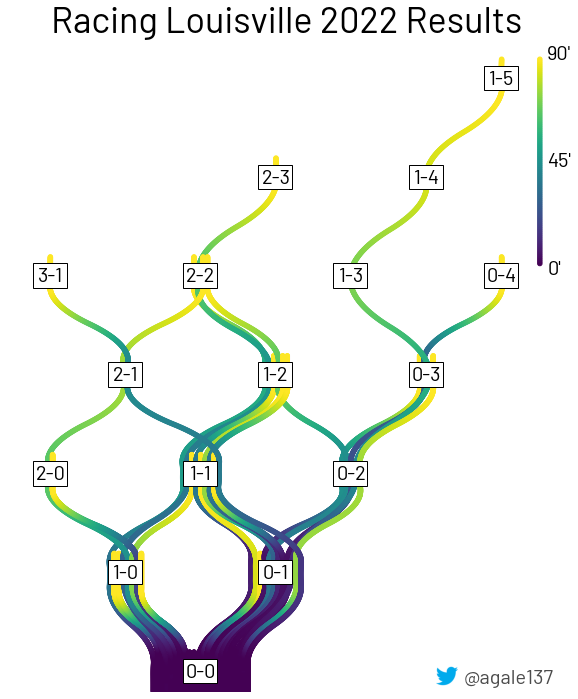

In [100]:
# General
plt.clf()
plt.rcParams["figure.figsize"] = (10, 12)
plt.figure(dpi=1200, facecolor="white")
fig, ax = plt.subplots()
fig.patch.set_facecolor("white")

# Plot lines
drawn = defaultdict(lambda: defaultdict(int))

ymax = 0
xmax = 0
xmin = 0

for i, game in enumerate(progression):
    x = []
    y = []
    c = []
    for minute, goal in game:
        new_x = goal[1] - goal[0]
        new_y = int(y[-1] + 0.8) if len(y) > 0 else 0

        lines_at_node = counts.get(new_y).get(new_x)
        lines_drawn = drawn[new_y][new_x]

        # Adjust to spread out lines at each node
        adjusted_x = new_x + (lines_drawn - lines_at_node / 2 + 0.5) * 0.06

        # Add two points so the line is straight when going through the node
        c.append(minute)
        x.append(adjusted_x)
        y.append(new_y - 0.2)
        c.append(minute)
        x.append(adjusted_x)
        y.append(new_y + 0.2)

        drawn[new_y][new_x] += 1

    # Convert from sparse x, y to interpolated points to add color
    x_points, y_points, c_points = calc_points(x, y, c)

    f = interp1d(y_points, x_points, kind="quadratic")
    y2 = np.linspace(y_points[0], y_points[-1], num=1000)
    x2 = f(y2)

    f2 = interp1d(y_points, c_points, kind="cubic")
    c2 = f2(y2)

    plt.scatter(
        x2,
        y2,
        s=20,
        c=c2,
        cmap="viridis",
    )

    ymax = max(ymax, y2[-1])
    xmax = max(xmax, max(x2))
    xmin = min(xmin, min(x2))

# Add score labels

# Constants for rendering labels
w = (xmax - xmin) * 0.075
h = ymax * 0.04
x_off = -0.01
y_off = 0.01

# Format the score based on the x and y coordinate
def format_scores(x_coord, y_coord):
    if x_coord == 0:
        return str(int(y_coord / 2)) + "-" + str(int(y_coord / 2))
    elif x_coord < 0:
        shared = y_coord + x_coord
        return str(int(shared / 2 - x_coord)) + "-" + str(int(shared / 2))
    else:
        shared = y_coord - x_coord
        return str(int(shared / 2)) + "-" + str(int(shared / 2 + x_coord))


# Iterate over all nodes that have lines through them to add labels
for y_node in counts.keys():
    for x_node in counts[y_node].keys():
        ax.text(
            x_node,
            y_node,
            format_scores(x_node, y_node),
            color="black",
            fontsize=20,
            fontproperties=Fonts.BARLOW,
            fontweight="bold",
            va="center",
            ha="center",
        )

        rect = patches.Rectangle(
            (x_node - w / 2 + x_off, y_node - h / 2 + y_off),
            w,
            h,
            linewidth=1,
            edgecolor="black",
            facecolor="white",
            zorder=2,
        )
        # add rectangle to plot
        ax.add_patch(rect)

# Legend
n_leg = 100
x_scat = np.repeat(xmax + 0.5, n_leg)
y_scat = np.linspace(ymax * 2 / 3, ymax, n_leg)
c_scat = np.linspace(0, 90, n_leg)

plt.scatter(
    x_scat,
    y_scat,
    s=20,
    c=c_scat,
    cmap="viridis",
)

ax.text(
    xmax + 0.5 + 0.1,
    ymax * 2 / 3 + 0.03,  # Small adjustment to align the 0'
    "0'",
    color="black",
    fontsize=20,
    fontproperties=Fonts.BARLOW,
    va="top",
    ha="left",
)
ax.text(
    xmax + 0.5 + 0.1,
    ymax * 5 / 6,
    "45'",
    color="black",
    fontsize=20,
    fontproperties=Fonts.BARLOW,
    va="center",
    ha="left",
)
ax.text(
    xmax + 0.5 + 0.1,
    ymax,
    "90'",
    color="black",
    fontsize=20,
    fontproperties=Fonts.BARLOW,
    va="baseline",
    ha="left",
)

# Title
plt.title(NWSL.NAMES[team] + " 2022 Results", fontproperties=Fonts.BARLOW, size=36)

# Axes
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylim([y2[0], ymax + 0.2])

# Username and Twitter logo
plt.text(
    0.98,
    0.02,
    "@agale137",
    transform=ax.transAxes,
    color="black",
    fontsize=20,
    alpha=0.7,
    fontproperties=Fonts.BARLOW,
    va="center",
    ha="right",
)
newax = fig.add_axes([0.72, 0.13, 0.03, 0.03], anchor="SE", zorder=1)
newax.imshow(Images.TWITTER)
newax.axis("off")

# Save image
plt.savefig(
    "score_progression_2022_" + team + ".png", bbox_inches="tight", pad_inches=0.5
)